**VALIDACION DEL MODELO**
- Basicament utilizando el algoritmo de neirest neighbors (k neirest neighbors con k = 1), en donde los puntos dados son los centroides calculados durante el entrenamiento, se busca clasificar una nueva fruta en el cluster de uno de loos centroides.

**LIBRERIAS**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import joblib
from scipy.spatial.distance import cdist

**PATHS**

In [2]:
image_path        = '../../../dataset/images'
validation_path   = os.path.join(image_path, 'validation')
original_path     = os.path.join(validation_path, 'original')
processed_path    = os.path.join(validation_path, 'processed')
training_data     = 'training_data.pkl'

**LISTAS DE IMAGENES**

In [3]:
original   = [os.path.join(original_path, image) for image in os.listdir(original_path)]
processed  = [os.path.join(processed_path, image) for image in os.listdir(processed_path)]

**PROCESAMIENTO DE LAS IMÁGENES**

In [ ]:
def get_light_background(mask, f = 20, p = 0.75):
    height, width = mask.shape
    cluster_size  = min([height, width])//f
    cluster       = np.ones((cluster_size, cluster_size), np.uint8)

    # Corners
    corner1 = np.bitwise_and(cluster, mask[:cluster_size,  :cluster_size])
    corner2 = np.bitwise_and(cluster, mask[:cluster_size:, -cluster_size:])
    corner3 = np.bitwise_and(cluster, mask[-cluster_size:, :cluster_size])
    corner4 = np.bitwise_and(cluster, mask[-cluster_size:, -cluster_size:])
    corners = [corner1, corner2, corner3, corner4]

    # Sides
    limitw1 = (width - cluster_size)//2
    limitw2 = (width + cluster_size)//2
    limith1 = (height - cluster_size)//2
    limith2 = (height + cluster_size)//2
    
    side1   = np.bitwise_and(cluster, mask[:cluster_size, limitw1:limitw2])
    side2   = np.bitwise_and(cluster, mask[limith1:limith2, :cluster_size])
    side3   = np.bitwise_and(cluster, mask[limith1:limith2, -cluster_size:])
    side4   = np.bitwise_and(cluster, mask[-cluster_size:, limitw1:limitw2])
    sides   = [side1, side2, side3, side4] 
    
    # Determining the type of background
    edges            = corners + sides
    light_background = sum(np.count_nonzero(edge) for edge in edges) > p*8*(cluster_size**2)

    # Inverting if dark background
    if light_background:
        return np.bitwise_not(mask)
    return mask    

In [ ]:
for file in original:
    # BGR image
    image = cv2.imread(file)

    # Dimenssions
    height, width, _ = image.shape
 
    # Pixel data vector
    data_vector = np.zeros((height * width, 4))

    # Obtener matrices del espacio de colores
    rgb_matrix = image.reshape((-1, 3))
    hsv_matrix = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).reshape((-1, 3))
    lab_matrix = cv2.cvtColor(image, cv2.COLOR_BGR2LAB).reshape((-1, 3))

    # Asignar a la matriz de datos
    # Conservamos el canal G, S, A y B
    data_vector[:, 0]  = rgb_matrix[:, 2]
    data_vector[:, 1]  = hsv_matrix[:, 1]
    data_vector[:, 2:] = lab_matrix[:, 1:]

    # Segmentamos la imagen con los vectores obtenidos pos cada pixel
    kmeans = KMeans(n_clusters = 2, n_init = 10)  # 2 Clusters. Background and fruit
    kmeans.fit(data_vector)

    # Get clusters labels
    labels = kmeans.labels_

    # kmeans_mask
    kmeans_mask = labels.reshape(height, width)
    kmeans_mask = kmeans_mask.astype(np.uint8) * 255

    # Determinación del tipo de fondo de la máscara
    kmeans_mask = get_light_background(kmeans_mask)

    # Erosion y dilataciòn sobre la màscara
    erosion_size      = min([height, width])//200
    dilatacion_size   = min([height, width])//80
    kernel_erosion    = np.ones((erosion_size,erosion_size), np.uint8)
    eroded            = cv2.erode(kmeans_mask, kernel_erosion, iterations = 1)
    kernel_dilatacion = np.ones((dilatacion_size,dilatacion_size), np.uint8)
    kmeans_mask       = cv2.dilate(eroded, kernel_dilatacion, iterations  = 2)

    # Encontrar contornos
    kmeans_cnt, _ = cv2.findContours(kmeans_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kmeans_cnt    = max(kmeans_cnt, key = cv2.contourArea)

    # Contorno aproximado
    epsilon       = 0.001 * cv2.arcLength(kmeans_cnt, True)
    kmeans_cnt    = cv2.approxPolyDP(kmeans_cnt, epsilon, True)
    kmeans_cnt    = (kmeans_cnt,)

    # Template
    tkmeans       = np.zeros((height, width), dtype=np.uint8)

    # Dibujar
    cv2.drawContours(tkmeans, kmeans_cnt, -1, 255, thickness = cv2.FILLED)

    # Guardar mascara
    cv2.imwrite(os.path.join(processed_path, os.path.basename(file)), tkmeans)

**RANGOS DE COLOR**

In [5]:
lower_red_2 = np.array([170, 60, 60])
upper_red_2 = np.array([179, 255, 255])

lower_red_1 = np.array([0, 60, 60])
upper_red_1 = np.array([8, 255, 255])

lower_orange = np.array([8, 120, 80])
upper_orange = np.array([21, 255, 255])

lower_yellow = np.array([21, 50, 80])
upper_yellow = np.array([25, 255, 255])

lower_green = np.array([25, 40, 40])
upper_green = np.array([100, 255, 255])

**EXTRACCIÓN DE CARACTERÍSTICAS**

In [7]:
conversion_color = {'V' :-20, 'R' : -10, 'A' : 10, 'N' : 20}
names            = [os.path.basename(file) for file in original]
image_features   = dict.fromkeys(names)

for image_file, mask_file in zip(original, processed):
    # Leer la imagen y la máscara
    image = cv2.imread(image_file)
    mask  = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Aplicar la máscara
    fruit = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)

    #---------------Extracción de los momentos de Hu----------------------

    # Encontrar el rectángulo delimitador de la fruta
    (x, y, w, h) = cv2.boundingRect(mask)

    # Recortar la imagen original para obtener solo la región de la fruta
    trimed  = fruit[y:y + h, x:x + w]

    # Convertir la imagen a escala de grises si es necesario
    trimed_gray = cv2.cvtColor(trimed, cv2.COLOR_BGR2GRAY)

    # Calcular los momentos de la imagen
    momentos = cv2.moments(trimed_gray)

    # Calcular los momentos de Hu
    momentos_hu = cv2.HuMoments(momentos)

    # Aplicar logaritmo a los momentos de Hu para mejorar la escala
    log_moments_hu = -np.sign(momentos_hu) * np.log10(np.abs(momentos_hu))
    moments = log_moments_hu.reshape(-1)

    #-----------------------Extracción de color-------------------------
    conteo = {
        'V' : np.sum(np.all(np.logical_and(lower_green  <= fruit, fruit <= upper_green), axis=-1)),
        'R1': np.sum(np.all(np.logical_and(lower_red_1  <= fruit, fruit <= upper_red_1), axis=-1)),
        'R2': np.sum(np.all(np.logical_and(lower_red_2  <= fruit, fruit <= upper_red_2), axis=-1)),
        'A' : np.sum(np.all(np.logical_and(lower_yellow <= fruit, fruit <= upper_yellow), axis=-1)),
        'N' : np.sum(np.all(np.logical_and(lower_orange <= fruit, fruit <= upper_orange), axis=-1))
    }
    conteo_por_rango = {
        'V': conteo['V'],
        'R': conteo['R1'] + conteo['R2'],
        'A': conteo['A'],
        'N': conteo['N']
    }

    sorted_conteo = sorted(conteo_por_rango.items(), key=lambda x: x[1], reverse=True)

    # Obtener el segundo elemento más grande
    segundo_mas_grande = sorted_conteo[1]

    # Obtener la etiqueta y el valor del segundo elemento más grande
    etiqueta_segundo_mas_grande = segundo_mas_grande[0]
    valor_segundo_mas_grande    = segundo_mas_grande[1]

    # Obtener la etiqueta basándose en el rango con el mayor conteo
    etiqueta = max(conteo_por_rango, key = conteo_por_rango.get)

    # Se usa el hecho de que a excepción de las manzanas, el resto de las frutas tienen poco rojo
    if (etiqueta_segundo_mas_grande == 'R')and(valor_segundo_mas_grande > 0.35*conteo_por_rango[etiqueta]):
        etiqueta = 'R'

    color = conversion_color[etiqueta]

    #-----------------Vector de características----------------------
    image_features[os.path.basename(image_file)] = np.append(moments[2:4], color)
    

**RECUPERAMOS LOS CENTROIDES Y APLICACIÓN DE KNN**

In [ ]:
def knn(training, test, k_n):
    X           = np.concatenate([v for v in training.values()], axis = 0)
    y           = np.concatenate([[k] * v.shape[0] for k, v in training.items()])
    dist        = cdist(test, X)
    sorted_ind  = np.argsort(dist, axis = 1)
    sorted_k    = sorted_ind[:, 0:k_n]
    predicted   = []
    
    for row in sorted_k:
        labels     = list(y[row])
        prediction = max(set(labels), key = labels.count)
        predicted.append(prediction)
    return predicted

In [ ]:
data                                         = joblib.load(training_data)
training_features,training_labels,centroids  = data['centroids']
prediction                                   = knn(centroids, np.vstack(list(image_features.values())), 1)

**REPRESENTACIÓN DE LAS IMÁGENES CON SUS ETIQUETAS**

In [ ]:
prediction = dict(zip(image_features.keys(), prediction))
total      = len(image_features.keys())
cols       = 4
rows       = total//cols
if len(total)%cols != 0:
    rows += 1

i = 0
for basename, label in prediction.items():

    file = os.path.join(original_path, basename)

    plt.figure(figsize = (10, 10))
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
    plt.title(basename)
    i += 1
plt.show()

**REPRESENTACIÓN DE LOS PUNTOS EN EL ESPACIO**

*Armamos los clusters del entrenamiento*

In [ ]:
points_matrix   = np.vstack(list(training_features.values()))
training_points = dict.fromkeys(set(training_labels))

for point, label in zip(points_matrix, training_labels):
    if training_points[label] is None:
        training_points[label] = []
    training_points[label].append(point)
    
points = dict()
for fruit, cluster in training_points.items():
    points[fruit] = np.vstack(cluster)

*Incorporamos los puntos de las frutas de validación al diccionario*

In [ ]:
points['validation'] = np.vstack(list(image_features.values()))

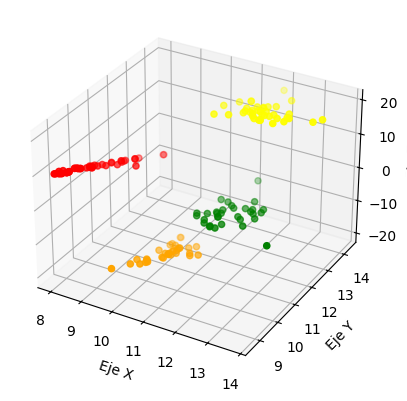

In [16]:
#3d
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')

color_values = []
for key in points:
    if key == 'naranja':
        color_values.append('orange')
    elif key == 'banana':
        color_values.append('yellow')
    elif key == 'pera':
        color_values.append('green')
    elif key == 'manzana':
        color_values.append('red')

colors = dict(zip(points.keys(), color_values))

for key, cluster in points.items():
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colors[key], marker='o', label=key)
        
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
plt.show()